In [1]:
import scanpy as sc
import squidpy as sq
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import Counter
from matplotlib_scalebar.scalebar import ScaleBar
import os

import cell2location
import scvi

DPI = 300
FONTSIZE = 20  # 42
sc.settings.set_figure_params(
    scanpy=True, dpi=100, transparent=True, vector_friendly=True, dpi_save=DPI
)
from matplotlib import rcParams

rcParams["pdf.fonttype"] = 42

from matplotlib import rcParams
import seaborn as sns
from pathlib import Path

# QC utils functions - a package
from vistools import utils
from vistools import spatial_plots

Global seed set to 0


## Prepare inputs for cell2location or any downstream analysis
* creating a single andata object containing multiple spatial samples. These samples have been QC already.v

In [2]:
# list of samples (names) to process
VIS_SAMPLE_LIST = ["Valdeolivas_2023_SN048_A416371_Rep1",
                   "Valdeolivas_2023_SN048_A416371_Rep2",
                  ]

# visium data path list
SP_DATA_DIR = Path(
    "/data/BCI-CRC/nasrine/data/CRC/spatial/public/Visium_Valdeolivas_2023/qc/"
)

# DIR2SAVE
DIR2SAVE = Path(
    "/data/BCI-CRC/nasrine/data/CRC/spatial/public/Visium_Valdeolivas_2023/concat_SN048_A416371/"
)

In [3]:
FIG2SAVE = DIR2SAVE.joinpath("figures/")
FIG2SAVE.mkdir(parents=True, exist_ok=True)
# set the global variable: sc.settings.figdir to save all plots
sc.settings.figdir = FIG2SAVE

In [4]:
VIS_SAMPLE_LIST

['Valdeolivas_2023_SN048_A416371_Rep1', 'Valdeolivas_2023_SN048_A416371_Rep2']

### Load adatas that have already undergone qc: nb genes, nb counts, find mt, ribo genes

In [5]:
# load adatas that have already undergone qc: nb genes, nb counts, find mt, ribo genes

# read first sample
print(f"Loading sample {VIS_SAMPLE_LIST[0]}")
adata = sc.read_h5ad(
    SP_DATA_DIR.joinpath(f"{VIS_SAMPLE_LIST[0]}/{VIS_SAMPLE_LIST[0]}_raw.h5ad")
)

# read the remaining samples
slides = (
    {}
)  # dictionary that will contain spatial adata, with light pre-processing done
for i in VIS_SAMPLE_LIST[1:]:
    print(f"Loading sample {i}")
    adata_1 = sc.read_h5ad(SP_DATA_DIR.joinpath(f"{i}/{i}_raw.h5ad"))
    slides[str(i)] = adata_1

adata_0 = adata.copy()

# combine individual samples
# adata = adata.concatenate(list(slides.values()), index_unique=None)
adata = adata.concatenate(
    list(slides.values()),
    batch_key="Sample_name",
    uns_merge="unique",
    batch_categories=VIS_SAMPLE_LIST,
    index_unique=None,
    join="inner"
    # join='outer'
)

slides[VIS_SAMPLE_LIST[0]] = adata_0

Loading sample Valdeolivas_2023_SN048_A416371_Rep1
Loading sample Valdeolivas_2023_SN048_A416371_Rep2


/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [6]:
adata.shape

(4120, 18613)

In [7]:
sc.pp.filter_cells(adata, min_genes=5)
sc.pp.filter_genes(adata, min_cells=3)

In [8]:
adata.shape

(4120, 18613)

In [10]:
adata.uns["spatial"].keys()

dict_keys(['Count_SN048_A416371_Rep1', 'Count_SN048_A416371_Rep2'])

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


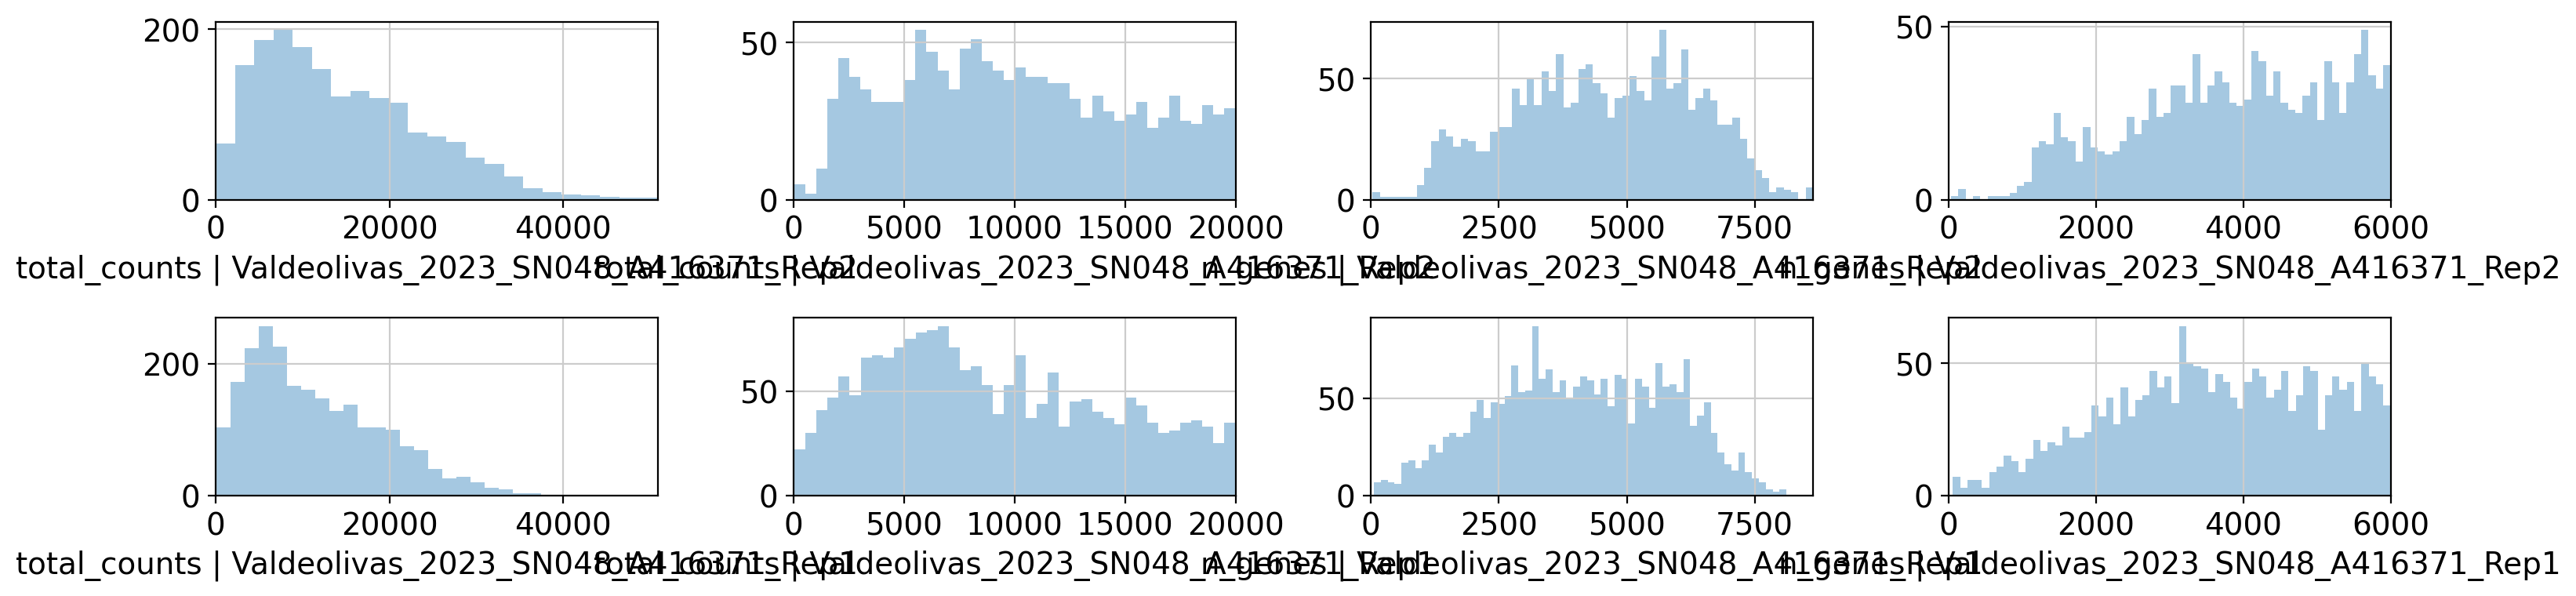

In [13]:
# PLOT QC FOR EACH SAMPLE
fig, axs = plt.subplots(len(slides), 4, figsize=(15, 4 * len(slides) - 4))
for i in range(len(slides)):
    # fig.suptitle('Covariates for filtering')

    sns.distplot(list(slides.values())[i].obs["total_counts"], kde=False, ax=axs[i, 0])
    axs[i, 0].set_xlim(0, adata.obs["total_counts"].max())
    axs[i, 0].set_xlabel("total_counts | " + list(slides.keys())[i])

    sns.distplot(
        list(slides.values())[i].obs["total_counts"][
            list(slides.values())[i].obs["total_counts"] < 20000
        ],
        kde=False,
        bins=40,
        ax=axs[i, 1],
    )
    axs[i, 1].set_xlim(0, 20000)
    axs[i, 1].set_xlabel("total_counts | " + list(slides.keys())[i])

    sns.distplot(
        list(slides.values())[i].obs["n_genes_by_counts"],
        kde=False,
        bins=60,
        ax=axs[i, 2],
    )
    axs[i, 2].set_xlim(0, adata.obs["n_genes_by_counts"].max())
    axs[i, 2].set_xlabel("n_genes | " + list(slides.keys())[i])

    sns.distplot(
        list(slides.values())[i].obs["n_genes_by_counts"][
            list(slides.values())[i].obs["n_genes_by_counts"] < 6000
        ],
        kde=False,
        bins=60,
        ax=axs[i, 3],
    )
    axs[i, 3].set_xlim(0, 6000)
    axs[i, 3].set_xlabel("n_genes | " + list(slides.keys())[i])

plt.tight_layout()
plt.savefig(
    FIG2SAVE.joinpath("hist_QC_covariates.pdf"),
    dpi=DPI,
    format="pdf",
    bbox_inches="tight",
)
plt.show()

In [14]:
adata.obs.describe()

,in_tissue,array_row,array_col,n_genes_by_counts,total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,n_genes
count,4120.0,4120.000000,4120.000000,4120.000000,4120.000000,4120.000000,4120.000000,4120.000000,4120.000000,4120.000000,4120.000000,4120.000000,4120.000000,4120.000000
mean,1.0,41.572573,55.046359,4297.663350,12864.144531,18.421825,27.421840,37.619842,52.363084,100.911163,1.001513,2211.470215,16.561010,4201.550971
std,0.0,13.583907,27.198202,1740.389528,8522.307617,2.740661,3.837424,4.746491,5.832553,87.391159,0.871214,1635.072144,2.486876,1733.919740
min,1.0,11.000000,2.000000,36.000000,36.000000,13.390929,20.086393,28.630306,43.027888,0.000000,0.000000,6.000000,7.633588,30.000000
25%,1.0,31.000000,34.000000,2994.000000,6068.750000,17.161500,25.641130,35.514205,49.505909,48.000000,0.425226,933.000000,14.872763,2899.750000
50%,1.0,42.000000,55.000000,4306.500000,11055.000000,18.227494,27.119969,37.181232,51.327002,75.000000,0.665657,1816.000000,16.369387,4210.500000
75%,1.0,52.250000,77.000000,5701.250000,18489.250000,19.374200,28.649176,39.014835,53.593678,120.000000,1.254534,3090.250000,18.025018,5599.250000
max,1.0,68.000000,115.000000,8640.000000,50895.000000,100.000000,100.000000,100.000000,100.000000,757.000000,9.002945,11153.000000,31.799164,8528.000000


In [15]:
adata.obs.Sample_name.cat.categories

Index(['Valdeolivas_2023_SN048_A416371_Rep1', 'Valdeolivas_2023_SN048_A416371_Rep2'], dtype='object')

In [16]:
adata.uns["Sample_colors"] = ["#ff7f00", "#984ea3"]

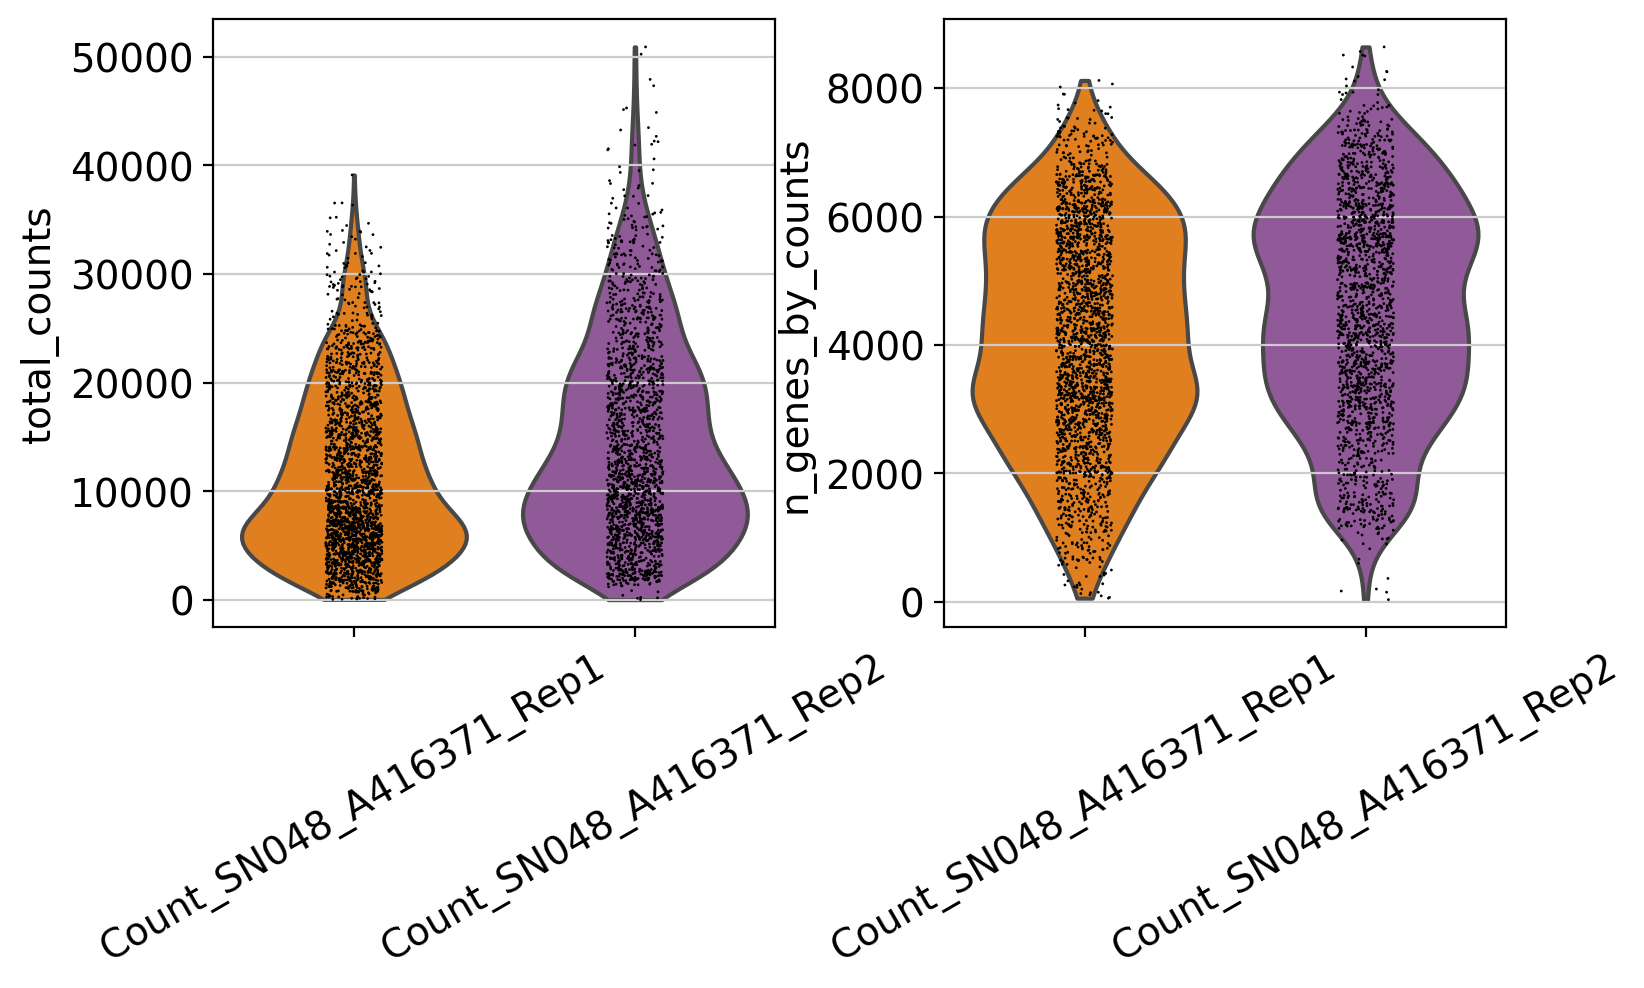

In [18]:
sc.pl.violin(
    adata,
    keys=["total_counts", "n_genes_by_counts"],
    groupby="Sample",
    multi_panel=True,
    rotation=30,
    jitter=0.1,
    save="QC_sample.pdf",
)

In [19]:
# load formatted and clean annotations
annot_path = Path(f"/data/BCI-CRC/nasrine/data/CRC/spatial/public/Visium_Valdeolivas_2023/cell2loc_pathologist_annotations/SN048_A416371_SN84_A120838_SN123_A595688/")

annot = pd.read_csv(annot_path.joinpath("cell2loc_mrna_abundance_pathological_annotations.csv"),
                    sep='\t',
                     header=0,
                 index_col=0)
annot.head(5)

,in_tissue,array_row,array_col,Sample,n_genes_by_counts,total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,...,UPR,cDC1,cDC2,gdT,ipEMT,migDC,pDC,pEMT,Pathologist Annotation grouped,Pathologist Annotations
spot_id,,,,,,,,,,,,,,,,,,,,,
Count_SN048_A416371_Rep1_AAACAAGTATCTCCCA-1,1,50,102,Count_SN048_A416371_Rep1,3447,6769.0,15.068696,22.972374,32.323829,47.215246,...,53,24,4,16,1958,22,2,915,tumor&stroma_IC med to high,NaN
Count_SN048_A416371_Rep1_AAACACCAATAACTGC-1,1,59,19,Count_SN048_A416371_Rep1,3706,8120.0,16.293103,24.445813,33.953202,48.374384,...,32,211,11,10,8041,15,5,78,tumor&stroma_IC med to high,NaN
Count_SN048_A416371_Rep1_AAACAGAGCGACTCCT-1,1,14,94,Count_SN048_A416371_Rep1,3809,7946.0,14.510446,22.048830,30.820539,45.117040,...,4,2,1,0,7,2,1,1,tumor&stroma_IC med to high,NaN
Count_SN048_A416371_Rep1_AAACAGCTTTCAGAAG-1,1,43,9,Count_SN048_A416371_Rep1,4381,10030.0,15.393819,23.110668,32.472582,46.749751,...,34,207,275,8,7570,13,26,21,tumor,NaN
Count_SN048_A416371_Rep1_AAACAGGGTCTATATT-1,1,47,13,Count_SN048_A416371_Rep1,1581,2543.0,17.066457,26.386158,38.969721,57.491152,...,11,111,5,6,1394,5,10,32,stroma_fibroblastic_IC high,NaN


In [20]:
adata.obs = adata.obs.merge(annot[['Pathologist Annotation grouped']],
                    how='left',
                    left_index=True,
                    right_index=True
                   )

In [22]:
# only select spots with valid annotations
adata = adata[~adata.obs['Pathologist Annotation grouped'].isin(['exclude', '', np.nan])].copy()
adata.shape

(4119, 18613)

In [24]:
adata.obs['Pathologist Annotation grouped'].value_counts()

tumor                          1299
tumor&stroma_IC med to high     917
stroma_fibroblastic_IC med      701
tumor&stroma                    651
stroma_fibroblastic_IC high     551
Name: Pathologist Annotation grouped, dtype: int64

In [25]:
palette_tissues_dict = {
    'tumor&stroma_IC med to high':'#E88BC4',
    'tumor':'#FDB462',
    'stroma_fibroblastic_IC high':'#8BE2E8',
    'stroma_fibroblastic_IC_high': '#8BE2E8',
    'stroma_fibroblastic_IC med':'#67A9CF',
    'stroma_fibroblastic_IC_med': '#67A9CF',
    'tumor&stroma_IC low':'#5DCFBB',
    'IC aggregate_stroma or muscularis': '#FEED8B',
    'stroma_fibroblastic_IC low': '#91CF60',
    'tumor&stroma': '#937F8C'
}


In [27]:
colors = [palette_tissues_dict[t] for t in sorted(set(adata.obs['Pathologist Annotation grouped']))]
colors

['#8BE2E8', '#67A9CF', '#FDB462', '#937F8C', '#E88BC4']

### Save to file

In [28]:
adata.write(DIR2SAVE.joinpath("Valdeolivas2023_concat_SN048_A416371_pCRC_raw.h5ad"))